In [9]:
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')
import run_six_utils as rsu
import lsst.afw.display as afwDisplay
import lsst.daf.butler as daf_butler
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.pyplot as plt
import numpy as np
import myutils_ar.myutils as myu
import eo_pipe

In [10]:
# repo = '/repo/main'
# operator = 'lsstccs'

# repo_arr = ['/repo/main','/repo/main','/repo/ir2','/repo/ir2']

# notable_detectors = ["R12_S20","R31_S01","R22_S01","R13_S01"]
# defect_list = ["BRIGHT_COLUMNS","BRIGHT_PIXELS"]

kwarg_dict = [{"alpha":.9,"ls":"-","marker":"+","markersize":10,"color":"red"},
              {"alpha":.9,"ls":"--","marker":"x","markersize":10,"color":"blue"},
              {"alpha":.9,"ls":"-.","marker":".","markersize":10,"color":"green"}]

## Using utils in `myutils.py` and `run_six_utils.py` to study specific amps

- Now, focus on the dark images only
- Look at darks with different exposures from the same B run
- Make a range of all of the dark frames, with timestamps and exptimes clearly labeled

In [11]:
# detector_amps = [("R11_S21",["C17"]), # Very bad amp, completely dead for Run 5
#                  ("R12_S20",["C17",   # In the BOT bad sensors page
#                              "C16"]), # In the BOT bad sensors page
detector_amps = [("R13_S01",["C17"]), # Centered at (4035,3115)
                 ("R13_S10",["C07"]), # Centered at (3929,1598)
                 ("R22_S01",["C11"]), # Centered at (644,2098)
                 ("R23_S10",["C13"]), # Centered at (1570,3760)
                 ("R31_S01",["C05"]), # Centered at (2966, 888)
                 ("R32_S10",["C04"])] # Centered at (2458, 294)

col_row =[(4035,3115),(3929,1598),(644,2098),(1570,3760),(2966, 888),(2458, 294)]

# ('12845','w_2023_22','/repo/main'),

run_week_repo = [('13162','w_2023_22','/repo/main'),
                 ('13401','w_2023_24','/repo/ir2'),
                 ('13550','w_2023_41','/repo/ir2')]  # Run 5, 6, run 6b.
weeklys = ['w_2023_22','w_2023_24','w_2023_41']
img_type = 'raw'
if_raw = True if img_type=="raw" else False
defect_datasets=["eoDarkDefects","eoBrightDefects"]
defect_dataset_path=["eo_dark_defects","eo_bright_defects"]
col_number = 2458
row_center = 294
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")

makeInset = False
scale=4

runList = [13035,13401,13550] # Add 12795? It's a run 4 B protocol run
repo = "/repo/main" if runList[0]>13999 else "/repo/ir2"

make_mask = False

colKwargs = {"marker":"."}

In [12]:
def criteriaMaker(image_type):
    if image_type=="BIAS":
        return {'IMGTYPE': 'BIAS'}
    elif image_type=="FLAT":
        return {'IMGTYPE': 'FLAT'}
    elif image_type=="DARK":
        return {'IMGTYPE': 'DARK'}

In [ ]:
for IMG_TYPE in ["DARK"]:
    for make_mask in [False]:
        for makeInset in [True,False]:        
            for det_amp,column_row in zip(detector_amps,col_row):
                col_number,row_center = column_row
                detector_str,amp_strs = det_amp
                detector_num = myu.det_nums[detector_str]
                    
                for amp_str in amp_strs:
                                
                    # Make a new figure

                    fig = 'mtv';
                    plt.close(fig);
                    fig = plt.figure(fig);

                    repo = "/repo/main" if runList[0]>13999 else "/repo/ir2"
                    refList = rsu.generateRefList(repo,collections,runList[0],img_type,detector_num,IMG_TYPE)
            
                    fig,axs = plt.subplots(len(runList),2*len(refList),figsize=[5*len(refList),20/3*len(runList)],sharey=True)
                    
                    # fig.suptitle()
                    for run,run_iter in zip(runList,range(len(runList))):
                        
                        repo = "/repo/main" if run>13999 else "/repo/ir2"
                        refList = rsu.generateRefList(repo,collections,run,img_type,detector_num,IMG_TYPE)
                        # allRefs = rsu.fetchAllRefs(repo,collections,[run],"raw",detector_num)
                        
                        for ref,ax_iter in zip(refList,range(len(refList))): # Needs to be changed for the three refs
                            img_axs = axs[run_iter, 2*ax_iter+1]
                            col_axs = axs[run_iter, ax_iter*2]
    
                            criteria = criteriaMaker(IMG_TYPE)
                            # Make a butler here in order to make image masks
                
                            collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
                            butler = daf_butler.Butler(repo,collections=collections) # Initializing a butler with the ir2 path and the above collections
                            registry = butler.registry
    
                            
                            img, detector_obj, amp = rsu.getAmpFromRefs(repo,collections,ref,amp_str)
    
                            # Everything after here 'should' be okay
                            
                            amp_array = img[amp.getBBox()].getImage().array
                            box,minx,maxx,miny,maxy = rsu.getAmpCorners(amp)
                            amp_min, amp_max = np.min(amp_array),np.max(amp_array)
                            if makeInset:
                                minx,maxx = col_number-10*scale,col_number+10*scale
                                miny,maxy = row_center-50*scale,row_center+50*scale
    
                                if minx < amp.getBBox().minX:
                                    minx = amp.getBBox().minX
                                    maxx = minx+20*scale
                                elif maxx > amp.getBBox().maxX:
                                    maxx = amp.getBBox().maxX
                                    minx = maxx-20*scale
                                if miny < amp.getBBox().minY:
                                    miny = amp.getBBox().minY
                                    maxy = miny+100*scale
                                elif maxy > amp.getBBox().maxY:
                                    maxy = amp.getBBox().maxY
                                    miny = maxy-100*scale
                                
                                inset_array = amp_array[int(miny-amp.getBBox().minY):int(maxy - amp.getBBox().minY),int(minx-amp.getBBox().minX):int(maxx - amp.getBBox().minX)]
                                low_scale,high_scale = np.quantile(inset_array,[0.1,0.9])
                            else:
                                low_scale,high_scale = np.quantile(amp_array,[0.1,0.9])
                                
                            # Mask image here
    
                            if make_mask:
                                kwargs={
                                        "datasetType": "",
                                        "collections": "",
                                        "where":
                                        """
                                        instrument='LSSTCam' and 
                                        detector = {var}
                                        """.format(var=detector_num)
                                        }
                    
                                for datasetType,defect_path in zip(defect_datasets,defect_dataset_path):
                                    img.getMask().addMaskPlane(datasetType)
                                    # here, add a new mask plane to add the mask.maskPixels to
                                    kwargs['datasetType'] = datasetType
                                    kwargs['collections'] = "u/lsstccs/"+defect_path+"_"+run+"_"+week
                                    # print("Querying",datasetType,"for mask")
                                    datasetRefs = list(registry.queryDatasets(**kwargs))
                                    count = 0
                                    for ref in datasetRefs:
                                        count+=1
                                    if count!=1:
                                        print("Error with {}: too many defects for {}!".format(run,datasetType))
                                    mask = butler.get(datasetRefs[0])
                                    
                                    mask.maskPixels(img,maskName=datasetType)
                
                            # End image masking 
                            
                            # add data to axes here
                
                            disp = afwDisplay.Display(fig)
                            disp.setImageColormap('inferno')
                            disp.frame.set_layout_engine('tight')
                            disp.frame.get_layout_engine().set(h_pad=.1, w_pad=.1, rect=(0,0.2, 1,0.8))
                            rsu.formatter(disp,kw=defect_datasets)
                            plt.sca(img_axs)
                            final_img = rsu.runISR(img).exposure
                            if not make_mask:
                                mtv_img = final_img
                            else:
                                mtv_img = final_img
                                
                            disp.scale("asinh","zscale")
                            
                            disp.mtv(mtv_img)
                            
                            # End adding data
                            
                            # format amp image here
                            if img_type !="raw":            
                                img_exptime = final_img.getMetadata().toDict()["CPP_INPUT_EXPT_0"]
                                img_acqtime = final_img.getMetadata().toDict()["DATE"]
                                img_temp = final_img.getMetadata().toDict()["CCDTEMP"]
                            else:
                                img_exptime = final_img.metadata.toDict()["EXPTIME"]
                                img_acqtime = final_img.metadata.toDict()["DATE"]
                                img_temp = final_img.metadata.toDict()["CCDTEMP"]
                            img_acqtime = str(np.datetime64(img_acqtime)).split('T')[1]
                            img_axs.set_title("Acquisition time: {}\nCCD Temp: {}\nExpTime: {}s".format(img_acqtime,img_temp,img_exptime))
                            img_axs.set_xlabel("Serial Register")
                            
                            img_axs.set_xlim(minx,maxx)
                            img_axs.set_xticks(np.arange(minx,maxx+1,step=int(np.floor((maxx-minx)/2))))
                            img_axs.set_ylim(miny,maxy)
                            img_axs.set_yticks(np.arange(miny,maxy,step=int(np.floor((maxy-miny)/6))))
                
                            # Now do the column axs
                            plt.sca(col_axs)
                            
                            halfMax = np.max(final_img.image.array.T[col_number])/2
                            
                            defect_x = final_img.image.array.T[col_number][final_img.image.array.T[col_number]>halfMax]
                            defect_y = np.arange(len(final_img.image.array.T[col_number]))[final_img.image.array.T[col_number]>halfMax]
                            
                            nondefect_x = final_img.image.array.T[col_number][final_img.image.array.T[col_number]<halfMax]
                            nondefect_y = np.arange(len(final_img.image.array.T[col_number]))[final_img.image.array.T[col_number]<halfMax]
                            
                            col_axs.scatter(defect_x,defect_y,color="red",label="Exceeding half-max",**colKwargs)
                            col_axs.scatter(nondefect_x,nondefect_y,color="green",label="Below half-max",**colKwargs)
                            col_axs.vlines(halfMax,miny,maxy,label="Half-max flux: {:.2E}".format(halfMax),ls='--',alpha=0.7)
                            col_axs.legend(fontsize="xx-small")
                            col_axs.set_title("{} - {}\nRun {}: Column {}\nDefect FWHM: {} pixels".format(detector_str+"_"+amp_str,IMG_TYPE,run,col_number,len(defect_y)))
                            col_axs.set_xlabel("Flux [e-]")
                            col_axs.grid()
                            col_axs.set_yticks(np.arange(miny,maxy,step=int(np.floor((maxy-miny)/6))))
                            col_axs.xaxis.set_major_formatter(rsu.ticker.FormatStrFormatter('%0.0e'))
                            col_axs.set_ylim(miny,maxy)
                            
                            # col_axs.plot(final_img.image.array.T[col_number],np.arange(len(final_img.image.array.T[col_number])))
                            # col_axs.set_title("{} - {}\nRun {}: Column {}".format(detector_str+"_"+amp_str,IMG_TYPE,run,col_number))
                            # col_axs.set_xlabel("Flux [e-]")
                            # col_axs.grid()
                            # col_axs.set_yticks(np.arange(miny,maxy,step=int(np.floor((maxy-miny)/6))))
                            # col_axs.xaxis.set_major_formatter(rsu.ticker.FormatStrFormatter('%0.0e'))
                            # col_axs.set_ylim(miny,maxy)
                            
                
                            if makeInset==False:                
                                plt.subplots_adjust(left=0,right=1,bottom=0.2,top=0.8,wspace=0.2,hspace=0.2)
                                
                            if makeInset==True:                
                                plt.subplots_adjust(left=0.2,right=0.8,bottom=0.2,top=0.8,wspace=0,hspace=0.2)
                
                        axs[run_iter, 0].set_ylabel("Parallel Register")
                        
                        # fig.set_constrained_layout(True)
    
                        xlim_low_old, xlim_high_old = 1E10,-1E10
                        for k in np.arange(0,6,step=2):
                            xlim_low, xlim_high = axs[run_iter,k].get_xlim()
                            if xlim_low < xlim_low_old:
                                xlim_low_old = xlim_low
                            if xlim_high > xlim_high_old:
                                xlim_high_old = xlim_high
                        for j in np.arange(0,6,step=2):
                            axs[run_iter,j].set_xlim(xlim_low_old,xlim_high_old)
                        
                        # fig.tight_layout()
                    
                    fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/AmpStudy_darks/{}{}{}_{}.jpg".format("NoMask_" if make_mask==False else "WithMask_","" if makeInset==False else "inset_",detector_str,amp_str),dpi=200)
                    
                    fig.clear()
                    plt.close(fig)

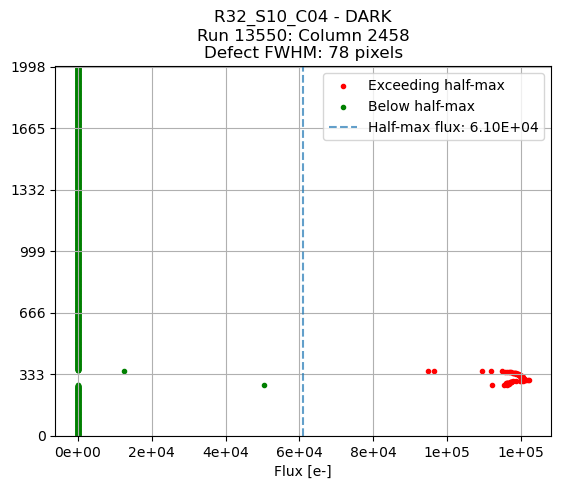

In [85]:
halfMax = np.max(final_img.image.array.T[col_number])/2

fig,ax = plt.subplots()

defect_x = final_img.image.array.T[col_number][final_img.image.array.T[col_number]>halfMax]
defect_y = np.arange(len(final_img.image.array.T[col_number]))[final_img.image.array.T[col_number]>halfMax]

nondefect_x = final_img.image.array.T[col_number][final_img.image.array.T[col_number]<halfMax]
nondefect_y = np.arange(len(final_img.image.array.T[col_number]))[final_img.image.array.T[col_number]<halfMax]

ax.scatter(defect_x,defect_y,color="red",label="Exceeding half-max",**colKwargs)
ax.scatter(nondefect_x,nondefect_y,color="green",label="Below half-max",**colKwargs)
ax.vlines(halfMax,miny,maxy,label="Half-max flux: {:.2E}".format(halfMax),ls='--',alpha=0.7)
ax.legend()
ax.set_title("{} - {}\nRun {}: Column {}\nDefect FWHM: {} pixels".format(detector_str+"_"+amp_str,IMG_TYPE,run,col_number,len(defect_y)))
ax.set_xlabel("Flux [e-]")
ax.grid()
ax.set_yticks(np.arange(miny,maxy,step=int(np.floor((maxy-miny)/6))))
ax.xaxis.set_major_formatter(rsu.ticker.FormatStrFormatter('%0.0e'))
ax.set_ylim(miny,maxy)

plt.show()

# Write code here to retrieve the CCD temperature of the raw dark images and plot them as a function of the exposure time

In [6]:
for IMG_TYPE in ["DARK"]:
    # for make_mask in [False]:
        # for makeInset in [True,False]:        
    for det_amp,column_row in zip(detector_amps,col_row):
        col_number,row_center = column_row
        detector_str,amp_strs = det_amp
        detector_num = myu.det_nums[detector_str]
        
        for amp_str in amp_strs:
            
            fig,ax = plt.subplots()
            
            for run,run_iter in zip(runList,range(len(runList))):
                
                repo = "/repo/main" if run>13999 else "/repo/ir2"
                refList = rsu.generateRefList(repo,collections,run,img_type,detector_num,IMG_TYPE)
                acq_time_arr = []
                img_temp_arr = []
                exp_time_arr = []
                for ref in refList: # Needs to be changed for the three refs

                    img, detector_obj, amp = rsu.getAmpFromRefs(repo,collections,ref,amp_str)

                    if img_type !="raw":            
                        img_exptime = img.getMetadata().toDict()["CPP_INPUT_EXPT_0"]
                        img_acqtime = img.getMetadata().toDict()["DATE"]
                        img_temp = img.getMetadata().toDict()["CCDTEMP"]
                    else:
                        img_exptime = img.metadata.toDict()["EXPTIME"]
                        img_acqtime = img.metadata.toDict()["DATE"]
                        img_temp = img.metadata.toDict()["CCDTEMP"]
                    img_acqtime = str(np.datetime64(img_acqtime)).split('T')[1]
                    
                    acq_time_arr.append(img_acqtime)
                    img_temp_arr.append(img_temp)
                    exp_time_arr.append(img_exptime)
                ax.plot(exp_time_arr,img_temp_arr,label="Run {}".format(run),marker='.')

            ax.legend()
            ax.grid()
            ax.set_xticks(np.arange(0,361,step=30))
            ax.set_xlim(-10,370)
            ax.set_yticks(np.arange(-110,-94,step=1))
            ax.set_ylim(-105,-98)
            ax.set_xlabel("Exposure time [s]")
            ax.set_ylabel("CCD Temperature [ºC]")
            ax.set_title("{}_{}".format(detector_str,amp_str))
        
            fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/AmpStudy_darks/Temperature_{}_{}.jpg".format(detector_str,amp_str),dpi=200)
            
            fig.clear()
            plt.close(fig)

29.599609375

# Debugging below

In [28]:
rsu.fetchAllRefs(repo,collections,[run],img_type,detector_num)

[DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 2023111600013, band: 'white', physical_filter: 'ef_43'}, run='LSSTCam/raw/all', id=21309581-3b74-56b4-bcfb-cc7c95292d17),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 2023111600008, band: 'white', physical_filter: 'ef_43'}, run='LSSTCam/raw/all', id=3100af69-a86c-5287-8b1c-5192387d8e57),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 2023111600009, band: 'white', physical_filter: 'ef_43'}, run='LSSTCam/raw/all', id=8ce33f0b-1b68-5044-993f-70b2a7f61079),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 2023111600011, band: 'white', physical_filter:

In [14]:
repo

'/repo/main'

In [12]:
img, detector_obj, amp

(<lsst.afw.image._exposure.ExposureF at 0x7fd7aa891970>,
 <lsst.afw.cameraGeom.Amplifier at 0x7fd7b2e1e5f0>)

In [17]:
for rwr in run_week_repo:
    run,week,repo = rwr
    allRefs = rsu.fetchAllRefs(repo,collections,[run],"raw",detector_num)
    recordDict = {"BIAS":[],"DARK":[],"FLAT":[]}
    print("Run {}".format(run))
    for r in allRefs:
        dc = rsu.getMetadataDict(r,rsu.makeButler(repo,collections))
        # if :
        if "FILTER" not in dc.keys() or dc["IMGTYPE"] not in recordDict.keys():
            continue
        else:
            
            if dc["FILTER"] not in recordDict[dc["IMGTYPE"]]:
                recordDict[dc["IMGTYPE"]].append(dc["FILTER"])
    print(recordDict)

Run 13162
{'BIAS': ['SDSSi'], 'DARK': ['SDSSi'], 'FLAT': ['SDSSi', 'SDSSg', 'SDSSr', 'SDSSu', 'SDSSY', 'SDSSz']}
Run 13401
{'BIAS': ['ef_43'], 'DARK': ['ef_43'], 'FLAT': ['ef_43']}


In [20]:
print(recordDict)

{'BIAS': ['ef_43'], 'DARK': ['ef_43'], 'FLAT': ['ef_43']}


In [8]:
allRefs = rsu.fetchAllRefs(repo,collections,[13550],"raw",detector_num)
recordDict = {"BIAS":[],"DARK":[],"FLAT":[]}
print("Run {}".format(run))
for r in allRefs:
    dc = rsu.getMetadataDict(r,rsu.makeButler(repo,collections))
    if dc["IMGTYPE"] not in recordDict.keys():
        continue
    else:
        if dc["EXPTIME"] not in recordDict[dc["IMGTYPE"]]:
            recordDict[dcc["IMGTYPE"]].append(dc["EXPTIME"])
print(recordDict)

NameError: name 'repo' is not defined

### Make a plot that looks through all the refs along a given column that you specify, try to use that to identify if one/multiple raws are contributing to the bright defects

## Make a diagnostic plot that shows the exptime of each image (y axis), based on the time the image was taken (x axis)

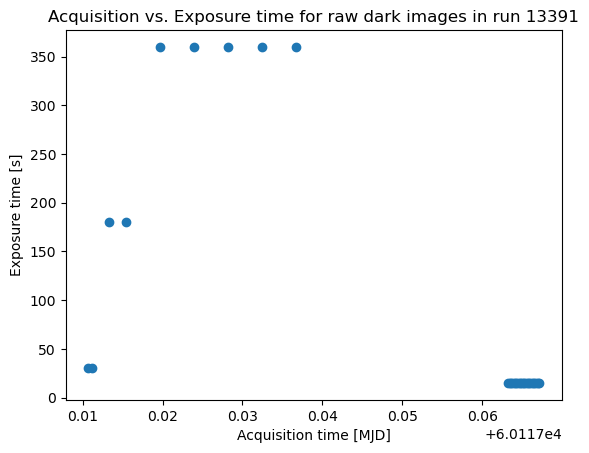

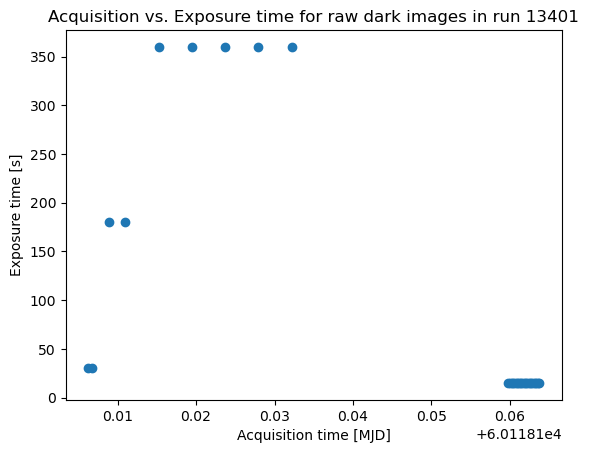

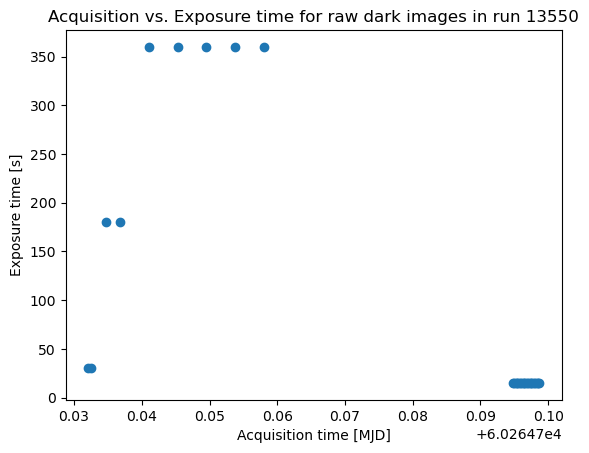

In [7]:
run_list=[13391,13401,13550]
for run in run_list:
    repo = "/repo/main" if run>13999 else "/repo/ir2"
    collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")
    allRefs = rsu.fetchAllRefs(repo,collections,[run],"raw",55)
    expTime,acqTime = [],[]
    for ref in allRefs:
        dic = rsu.getMetadataDict(ref,rsu.makeButler(repo,collections))
        if dic["IMGTYPE"]=="DARK":
            acqTime.append(dic["MJD"])
            expTime.append(dic["EXPTIME"])
    fig,ax = plt.subplots()
    ax.scatter(acqTime,expTime)
    ax.set_xlabel("Acquisition time [MJD]")
    ax.set_ylabel("Exposure time [s]")
    ax.set_title("Acquisition vs. Exposure time for raw dark images in run {}".format(run))
    plt.show()

In [ ]:
# np.max(expTime)
# expTime[0]
# expTime[-1]

In [14]:
exposrr = rsu.makeButler(repo,collections).get(allRefs[2])

In [22]:
allRefs

[DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200255, band: 'y', physical_filter: 'SDSSY'}, run='LSSTCam/raw/all', id=44111c77-088a-5f46-8723-084ae111ef16),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200251, band: 'g', physical_filter: 'SDSSg'}, run='LSSTCam/raw/all', id=a61f25ed-695d-59ba-b3d7-27e4b789a9e4),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200240, band: 'i', physical_filter: 'SDSSi'}, run='LSSTCam/raw/all', id=1d1c0500-1bce-5f14-883a-26693a4fddea),
 DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 55, exposure: 3021121200241, band: 'i', physical_filter: 'SDSSi'}, run='

In [8]:
rsu.getMetadataDict(refList[2],rsu.makeButler(repo,collections))

{'SIMPLE': True,
 'EXTEND': True,
 'DATE': '2023-11-16T17:47:08.324',
 'MJD': 60264.74106856482,
 'RUNNUM': '13550',
 'CCD_MANU': 'E2V',
 'CCD_TYPE': 'CCD250',
 'TESTTYPE': 'DARK',
 'IMGTYPE': 'DARK',
 'DETSIZE': '[1:4096,1:4004]',
 'EXPTIME': 360.0,
 'FILENAME': 'MC_C_20231116_000037_R32_S10.fits',
 'BINX': 1,
 'BINY': 1,
 'CCDGAIN': 1.0,
 'CCDNOISE': 10.0,
 'DATE-OBS': '2023-11-16T17:41:08.230',
 'MJD-OBS': 60264.73690081015,
 'DATE-TRG': '2023-11-16T17:47:08.316',
 'MJD-TRG': 60264.741068472154,
 'IMAGETAG': '9f8063b255acb9b0',
 'CCDSLOT': 'S10',
 'RAFTBAY': 'R32',
 'FIRMWARE': '3139500e',
 'PLATFORM': 'ir2-camera',
 'CONTNUM': '18ee04ae',
 'DAQVERS': 'R5-V6.9 2023-09-11T17:05:01Z (9eb7c3ed)',
 'DAQPART': 'camera',
 'DAQFOLD': 'raw',
 'OBSANNOT': '',
 'OBSID': 'MC_C_20231116_000037',
 'CAMCODE': 'MC',
 'CONTRLLR': 'C',
 'DAYOBS': '20231116',
 'SEQNUM': 37,
 'HEADVER': 2,
 'INSTRUME': 'lsstCam',
 'TELESCOP': 'LSST',
 'TSTAND': 'BOT',
 'SEQFILE': 'FP_E2V_2s_ir2_v26.seq',
 'SEQCKSUM': 

In [33]:
mDict = rsu.getMetadataDict(allRefs[-5],rsu.makeButler(repo,collections))

In [38]:
mDict["FILTER1"]

'nm750'

In [23]:
for r in rsu.fetchAllRefs(repo,collections,[13550],"raw",90):
    mDict = rsu.getMetadataDict(allRefs[0],rsu.makeButler(repo,collections))
    print(mDict["FILTER"],mDict["IMGTYPE"])

ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS
ef_43 BIAS

KeyboardInterrupt: 

In [137]:
allRefs = rsu.fetchAllRefs(repo,collections,[13550],"raw",90)

ite = 0
for r in allRefs:
    if str(r.id) == "522e1883-fcdc-585d-becb-725905446ef6":
        print(r,ite)
    ite+=1

raw@{instrument: 'LSSTCam', detector: 90, exposure: 2023111600082, band: 'white', physical_filter: 'ef_43~HIGH'} [sc=Exposure] (run=LSSTCam/raw/all id=522e1883-fcdc-585d-becb-725905446ef6) 227


In [181]:
reference_ref = allRefs[227]

<Figure size 640x480 with 0 Axes>

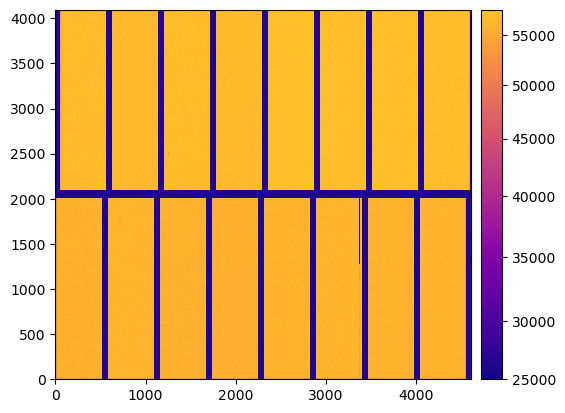

In [194]:
image = rsu.makeButler(repo,collections).get(reference_ref)
fig = 'mtv';
plt.close(fig);
fig = plt.figure(fig);

fig,axs = plt.subplots()
# fig.suptitle("{var0}, detector {var1}, Run {var3}".format(var0=img_type,var1=90,var3=run_number))

disp = afwDisplay.Display(fig)
disp.setImageColormap('plasma')
disp.scale('asinh','zscale',Q=1)

rsu.formatter(disp)
plt.sca(axs)

disp.mtv(image)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f909e349580> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

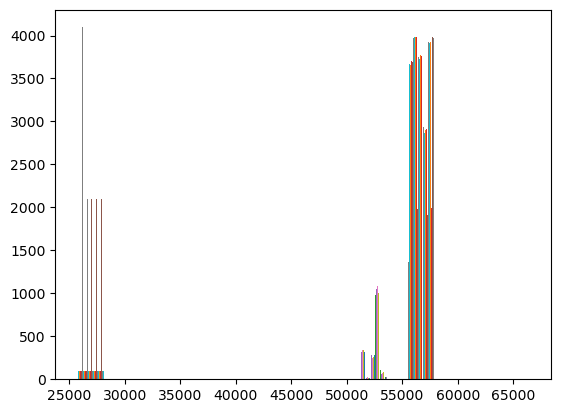

In [183]:
plt.hist(image.getImage().array)